In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Baixando recursos NLKT (apenas uma vez)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error Tunnel connection
[nltk_data]     failed: 407 Proxy Authorization Required>
[nltk_data] Error loading stopwords: <urlopen error Tunnel connection
[nltk_data]     failed: 407 Proxy Authorization Required>


False

In [5]:
treino = pd.read_csv("train.csv", sep=",")
teste = pd.read_csv("test.csv", sep=",")

treino['base'] = 'treino'
teste['base'] = 'teste'

In [7]:
data = pd.concat([treino, teste], ignore_index = True)
data['text'] = data['text'].astype(str)

In [9]:
def preprocess(text):

    #Tokenização
    tokens = word_tokenize(text.lower())

    #Remoção de stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    #Stemming
    tokens = [stemmer.stem(token) for token in tokens]

    #Reune os tokens em uma string
    processed_text = ' '.join(tokens)

    return processed_text

In [11]:
stemmer = PorterStemmer()
data['processed_text'] = data['text'].apply(preprocess)

In [13]:
data_treino = data[data['base'] == 'treino'].copy()
data_teste = data[data['base'] == 'teste'].copy()

In [15]:
data_teste.drop('label', axis=1, inplace=True)
data_teste.head()

,id,title,author,text,base,processed_text
20800,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",teste,"palo alto , calif. — year scorn polit process ..."
20801,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,teste,russian warship readi strike terrorist near al...
20802,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,teste,video # nodapl : nativ american leader vow sta...
20803,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",teste,"first ’ succeed , tri differ sport . tim tebow..."
20804,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,teste,42 min ago 1 view 0 comment 0 like 'for first ...


In [19]:
data_submit = pd.read_csv("submit.csv", sep=",")

In [21]:
data_teste = pd.merge(data_teste, data_submit, on='id', how='left')

In [23]:
data_treino.drop('base', axis=1, inplace=True)
data_teste.drop('base', axis=1, inplace=True)

In [25]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(data_treino['processed_text'])  
y_train = data_treino['label']
x_test = vectorizer.transform(data_teste['processed_text'])  
y_test = data_teste['label']

In [27]:
model = MultinomialNB()

In [29]:
param_grid = {
    'alpha': [0.1, 1, 10],
    'fit_prior': [True, False]
}

# Treinando o modelo com GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train, data_treino['label'])

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 1, 10], 'fit_prior': [True, False]},
             scoring='accuracy')

In [31]:
best_params = grid_search.best_params_

In [33]:
modelo = MultinomialNB(**best_params)
modelo.fit(x_train, data_treino['label'])

MultinomialNB(alpha=0.1)

In [35]:
y_pred = modelo.predict(x_test)

In [37]:
accuracy = accuracy_score(data_submit['label'], y_pred)
print(f"Acurácia do modelo: {accuracy:.4f}")

Acurácia do modelo: 0.6021


In [39]:
print(classification_report(data_submit['label'], y_pred))

              precision    recall  f1-score   support

           0       0.55      0.67      0.60      2339
           1       0.67      0.54      0.60      2861

    accuracy                           0.60      5200
   macro avg       0.61      0.61      0.60      5200
weighted avg       0.62      0.60      0.60      5200



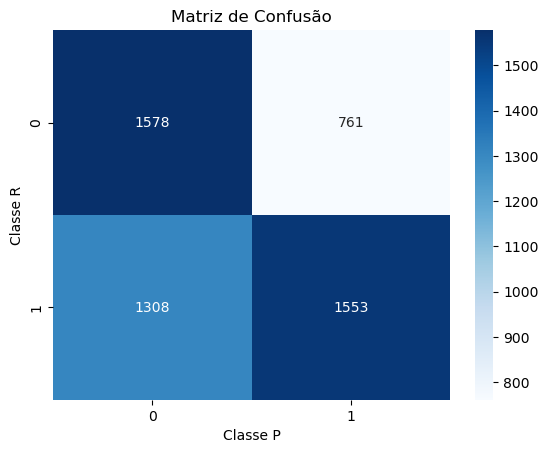

In [43]:
from sklearn.metrics import confusion_matrix

confusionm = confusion_matrix(data_submit['label'], y_pred)
classes = [0,1]
sns.heatmap(confusionm, annot=True, xticklabels=classes, yticklabels=classes, fmt='d', cmap='Blues')
plt.xlabel('Classe P')
plt.ylabel('Classe R')
plt.title('Matriz de Confusão')
plt.show()

In [45]:
confusionm

array([[1578,  761],
       [1308, 1553]], dtype=int64)

In [51]:
print(f"Tamanho de data_submit['label']: {len(data_submit['label'])}")
print(f"Tamanho de y_pred: {len(y_pred)}")
print(f"Tamanho de x_test: {x_test.shape[0]}")
print(f"Tamanho de data_teste: {len(data_teste)}")

Tamanho de data_submit['label']: 5200
Tamanho de y_pred: 5200
Tamanho de x_test: 5200
Tamanho de data_teste: 5200


In [57]:
feature_names = vectorizer.get_feature_names_out()
log_probs = modelo.feature_log_prob_  
coef_df = pd.DataFrame({'Palavra': feature_names})
for i, class_name in enumerate(modelo.classes_):
    coef_df[f'Log Probabilidade {class_name}'] = log_probs[i]
coef_df = coef_df.sort_values(by='Log Probabilidade 1.0', ascending=False)

In [59]:
top_positive = coef_df.head(20)
top_negative = coef_df.tail(20)

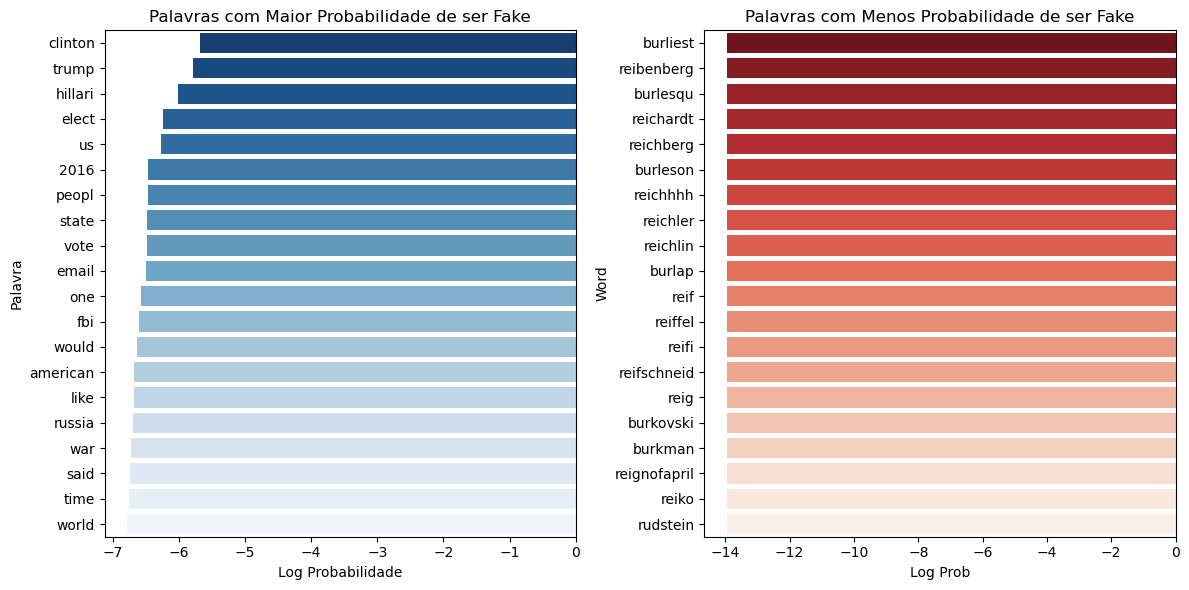

In [67]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Log Probabilidade 1.0', y='Palavra', data=top_positive, orient='h', palette='Blues_r')
plt.title('Palavras com Maior Probabilidade de ser Fake')
plt.xlabel('Log Probabilidade')
plt.ylabel('Palavra')

plt.subplot(1, 2, 2)
sns.barplot(x='Log Probabilidade 1.0', y='Palavra', data=top_negative, orient='h', palette='Reds_r')
plt.title('Palavras com Menos Probabilidade de ser Fake')
plt.xlabel('Log Prob')
plt.ylabel('Word')
plt.tight_layout()
plt.show()